In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
bbsr = pd.read_csv("bbsr_yearly.csv")
delhi = pd.read_csv("delhi_mly.csv")

bbsr.columns = bbsr.columns.str.strip()       # remove leading/trailing spaces
bbsr.columns = bbsr.columns.str.replace(" ", "")  # remove internal spaces if any
delhi.columns = delhi.columns.str.strip()
delhi.columns = delhi.columns.str.replace(" ", "")


   year   AQI_Delhi  AQI_Bhubaneswar  Delhi_Growth(%)  Bbsr_Growth(%)
0  2022  227.626215       128.670743              NaN             NaN
1  2023  190.841711       156.154036       -16.160047       21.359396
2  2024  201.530105        99.340711         5.600659      -36.382874


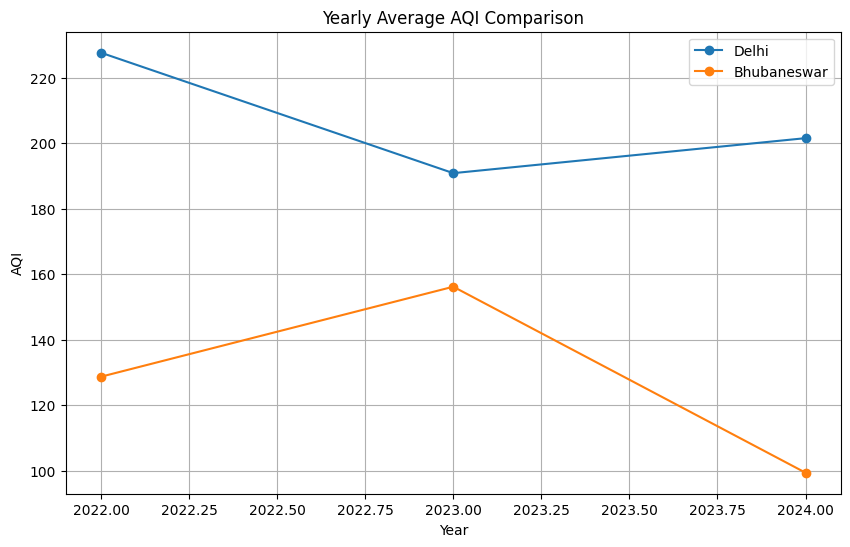

In [13]:

# 1. CPCB AQI Breakpoints (India)
# ----------------------------
# Breakpoints dictionary for major pollutants
# Format: pollutant: [(low, high, index_low, index_high), ...]

breakpoints = {
    "PM2.5": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
              (91, 120, 201, 300), (121, 250, 301, 400), (251, 500, 401, 500)],
    
    "PM10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 600, 401, 500)],
    
    "NO2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 600, 401, 500)],
    
    "Ozone": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
              (169, 208, 201, 300), (209, 748, 301, 500)],
    
    "NH3": [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
            (801, 1200, 201, 300), (1201, 1800, 301, 400), (1801, 2000, 401, 500)]
}

# ----------------------------
# 2. Function to calculate Sub-Index & AQI
# ----------------------------
def calculate_subindex(concentration, pollutant):
    """Calculate subindex for a given pollutant concentration"""
    if pollutant not in breakpoints:
        return None
    for (Clow, Chigh, Ilow, Ihigh) in breakpoints[pollutant]:
        if Clow <= concentration <= Chigh:
            return ((Ihigh - Ilow) / (Chigh - Clow)) * (concentration - Clow) + Ilow
    return None  # if outside range

def calculate_aqi(row):
    sub_indices = []
    for pollutant in ["PM2.5", "PM10", "NO2", "Ozone", "NH3"]:
        if pollutant in row and pd.notnull(row[pollutant]):
            sub_index = calculate_subindex(row[pollutant], pollutant)
            if sub_index is not None:
                sub_indices.append(sub_index)
    if sub_indices:
        return max(sub_indices)  # AQI = max of sub-indices
    return np.nan

# ----------------------------
# 3. Load Delhi & Bhubaneswar datasets
# ----------------------------
bbsr = pd.read_csv("bbsr_yearly.csv")
delhi = pd.read_csv("delhi_mly.csv")

# Clean column names (strip spaces)
delhi.columns = delhi.columns.str.strip()
bbsr.columns = bbsr.columns.str.strip()

# Find common years
common_years = set(delhi['year']).intersection(set(bbsr['year']))

# Filter both datasets
delhi = delhi[delhi['year'].isin(common_years)]
bbsr = bbsr[bbsr['year'].isin(common_years)]

# Drop existing AQI from Delhi (to recompute fresh)
if "AQI" in delhi.columns:
    delhi = delhi.drop(columns=["AQI"])

# Compute AQI for both
delhi["AQI"] = delhi.apply(calculate_aqi, axis=1)
bbsr["AQI"] = bbsr.apply(calculate_aqi, axis=1)

# ----------------------------
# 4. Yearly Averages & Growth Rates
# ----------------------------
delhi_yearly = delhi.groupby("year")["AQI"].mean().reset_index()
bbsr_yearly = bbsr.groupby("year")["AQI"].mean().reset_index()

# Merge for comparison
comparison = delhi_yearly.merge(bbsr_yearly, on="year", suffixes=("_Delhi", "_Bhubaneswar"))

# Growth rate = % change YoY
comparison["Delhi_Growth(%)"] = comparison["AQI_Delhi"].pct_change() * 100
comparison["Bbsr_Growth(%)"] = comparison["AQI_Bhubaneswar"].pct_change() * 100

print(comparison)

# ----------------------------
# 5. Plot Comparison
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(comparison["year"], comparison["AQI_Delhi"], marker="o", label="Delhi")
plt.plot(comparison["year"], comparison["AQI_Bhubaneswar"], marker="o", label="Bhubaneswar")
plt.title("Yearly Average AQI Comparison")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()


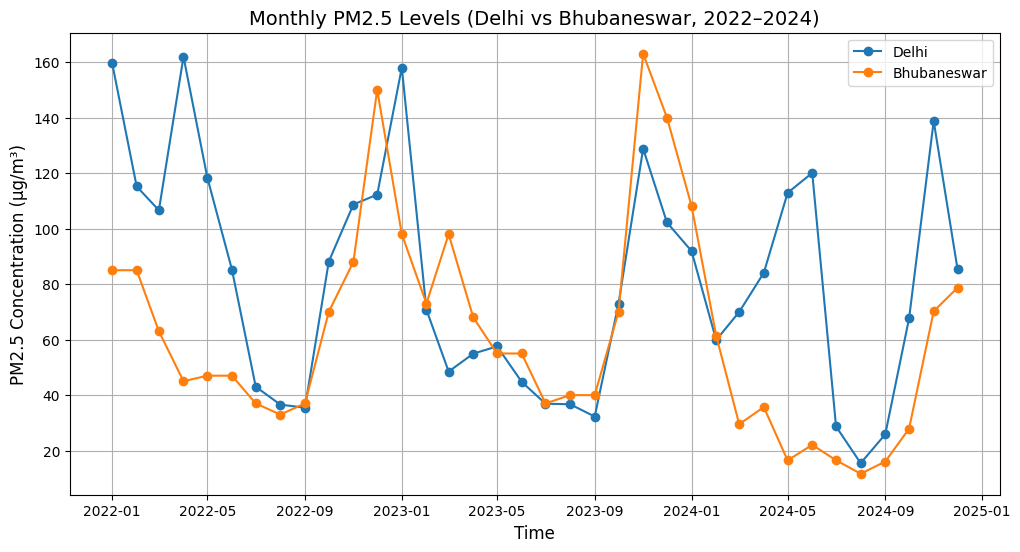

In [15]:
# Keep only relevant columns
delhi2 = delhi[['year', 'month', 'PM2.5']].copy()
bbsr2 = bbsr[['year', 'month', 'PM2.5']].copy()

# Add city labels
delhi2['city'] = "Delhi"
bbsr2['city'] = "Bhubaneswar"

# Combine datasets
data = pd.concat([delhi, bbsr])

# Create a proper datetime column for x-axis
data['date'] = pd.to_datetime(data['year'].astype(str) + "-" + data['month'].astype(str) + "-01")

# Plot monthly PM2.5 trends
plt.figure(figsize=(12,6))
for city in data['city'].unique():
    subset = data[data['city'] == city]
    plt.plot(subset['date'], subset['PM2.5'], marker='o', label=city)

plt.title("Monthly PM2.5 Levels (Delhi vs Bhubaneswar, 2022–2024)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Concentration (µg/m³)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


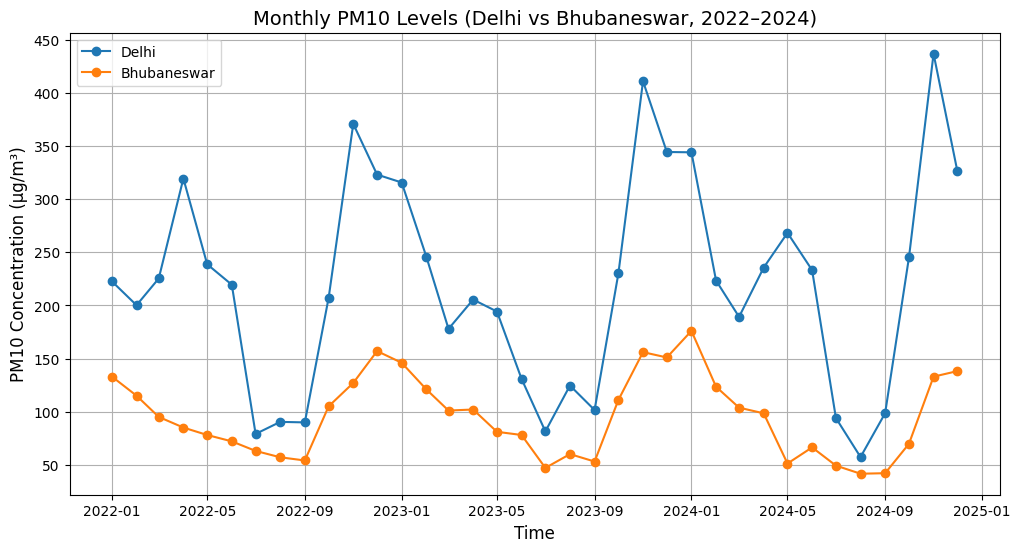

In [16]:
# Keep only relevant columns for PM10
delhi3 = delhi[['year', 'month', 'PM10']].copy()
bbsr3 = bbsr[['year', 'month', 'PM10']].copy()

# Add city labels
delhi3['city'] = "Delhi"
bbsr3['city'] = "Bhubaneswar"

# Combine datasets
data_pm10 = pd.concat([delhi3, bbsr3])

# Create datetime
data_pm10['date'] = pd.to_datetime(data_pm10['year'].astype(str) + "-" + data_pm10['month'].astype(str) + "-01")

# Plot monthly PM10 trends
plt.figure(figsize=(12,6))
for city in data_pm10['city'].unique():
    subset = data_pm10[data_pm10['city'] == city]
    plt.plot(subset['date'], subset['PM10'], marker='o', label=city)

plt.title("Monthly PM10 Levels (Delhi vs Bhubaneswar, 2022–2024)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM10 Concentration (µg/m³)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
